<a href="https://colab.research.google.com/github/harshavardhangadila/Training-Neural-networks-with-Keras/blob/main/Part%201/I_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Keras Tuner if not already installed
!pip install -q -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.6 MB/s eta 0:00:00


In [2]:
# Import libraries
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import datetime

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical


In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values and expand dimensions
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set shape: (60000, 28, 28, 1)
Testing set shape: (10000, 28, 28, 1)


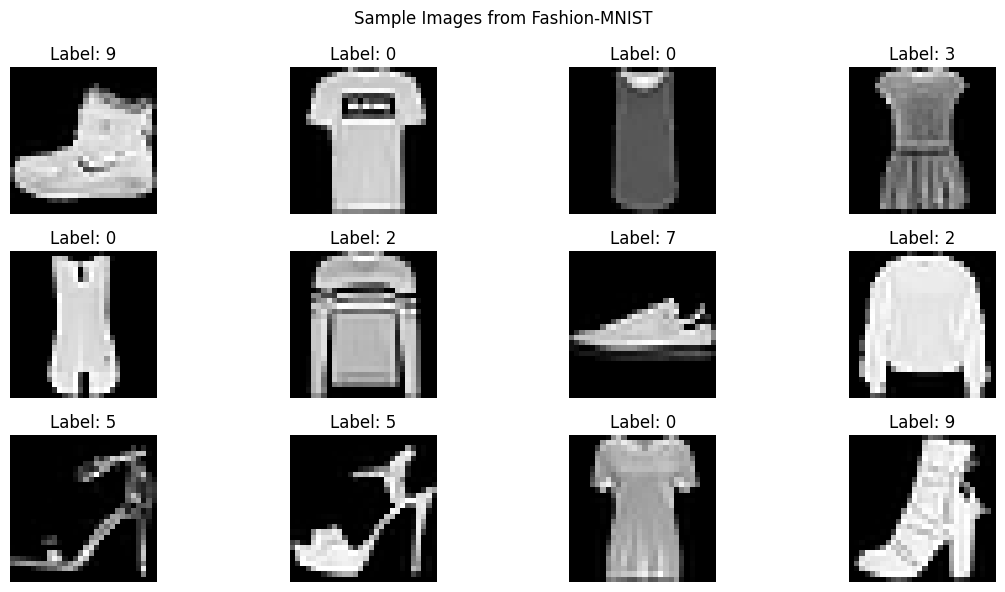

In [4]:
# Plot sample images
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample Images from Fashion-MNIST")
plt.tight_layout()
plt.show()


In [5]:
# Define a model builder for Keras Tuner
def model_builder(hp):
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Flatten(),

        # Tune the number of units
        layers.Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=32),
            activation='relu'
        ),

        # Tune the dropout rate
        layers.Dropout(
            rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
        ),

        layers.Dense(10, activation='softmax')
    ])

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [6]:
# Initialize Hyperband tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='kt_fashion_mnist'
)

print("Tuner initialized. Ready for hyperparameter search.")


Tuner initialized. Ready for hyperparameter search.


In [7]:
# Early stopping to avoid overfitting
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [8]:
# Perform the search
tuner.search(
    x_train, y_train_cat,
    epochs=10,
    validation_data=(x_test, y_test_cat),
    callbacks=[early_stopping_cb]
)


Trial 30 Complete [00h 00m 44s]
val_accuracy: 0.8219000101089478

Best val_accuracy So Far: 0.8838000297546387
Total elapsed time: 00h 13m 32s


In [9]:
# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best number of units: 256
Best dropout rate: 0.2
Best learning rate: 0.001


In [10]:
# Build model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    batch_size=64,
    verbose=2
)


Epoch 1/10
938/938 - 5s - 6ms/step - accuracy: 0.8140 - loss: 0.5253 - val_accuracy: 0.8496 - val_loss: 0.4206
Epoch 2/10
938/938 - 4s - 4ms/step - accuracy: 0.8607 - loss: 0.3911 - val_accuracy: 0.8577 - val_loss: 0.3999
Epoch 3/10
938/938 - 4s - 5ms/step - accuracy: 0.8678 - loss: 0.3575 - val_accuracy: 0.8574 - val_loss: 0.3886
Epoch 4/10
938/938 - 3s - 3ms/step - accuracy: 0.8782 - loss: 0.3332 - val_accuracy: 0.8712 - val_loss: 0.3562
Epoch 5/10
938/938 - 3s - 3ms/step - accuracy: 0.8834 - loss: 0.3167 - val_accuracy: 0.8729 - val_loss: 0.3479
Epoch 6/10
938/938 - 3s - 3ms/step - accuracy: 0.8885 - loss: 0.3027 - val_accuracy: 0.8743 - val_loss: 0.3422
Epoch 7/10
938/938 - 2s - 2ms/step - accuracy: 0.8903 - loss: 0.2953 - val_accuracy: 0.8815 - val_loss: 0.3338
Epoch 8/10
938/938 - 2s - 2ms/step - accuracy: 0.8945 - loss: 0.2840 - val_accuracy: 0.8748 - val_loss: 0.3407
Epoch 9/10
938/938 - 3s - 3ms/step - accuracy: 0.8975 - loss: 0.2758 - val_accuracy: 0.8837 - val_loss: 0.3257
E

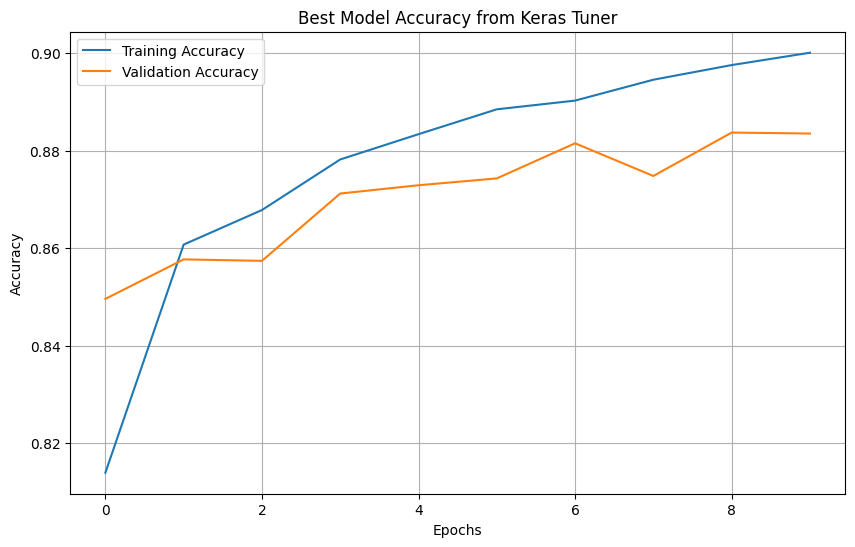

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Best Model Accuracy from Keras Tuner")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Evaluate the final model
test_loss, test_acc = best_model.evaluate(x_test, y_test_cat, verbose=2)
print(f"Test Accuracy of best model: {test_acc:.4f}")


313/313 - 1s - 3ms/step - accuracy: 0.8835 - loss: 0.3251
Test Accuracy of best model: 0.8835


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


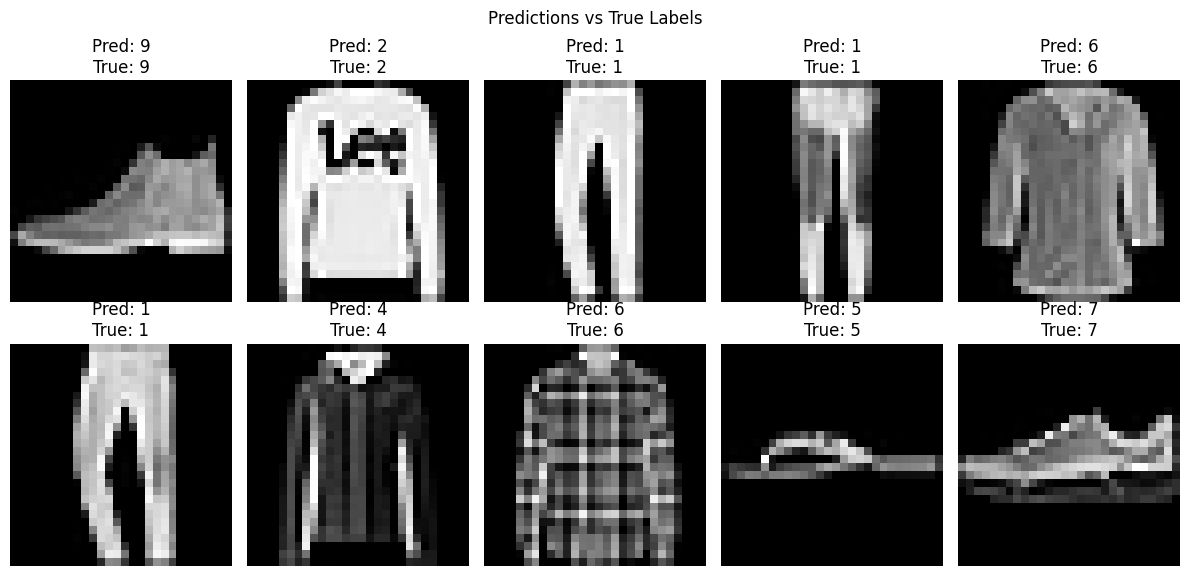

In [13]:
# Predict on a few test samples
predictions = best_model.predict(x_test[:10])
predicted_labels = np.argmax(predictions, axis=1)

# Plot predictions vs true labels
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {y_test[i]}")
    plt.axis('off')
plt.suptitle("Predictions vs True Labels")
plt.tight_layout()
plt.show()
